In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [39]:
from helpers import load_data, preprocess_data

#location of data
path_dataset = "../data/data_train.csv"
subset = [100, 101]
ratings = load_data(path_dataset, subset)
#ratings = load_data(path_dataset)
print("shape of dataset:",ratings.shape)
#print(ratings)
#print( ratings[0,9])
#print( ratings[0:5,0:5])
#ratings

number of items: 10000, number of users: 1000
shape of dataset: (100, 101)


### Plot the number of ratings per movie and user

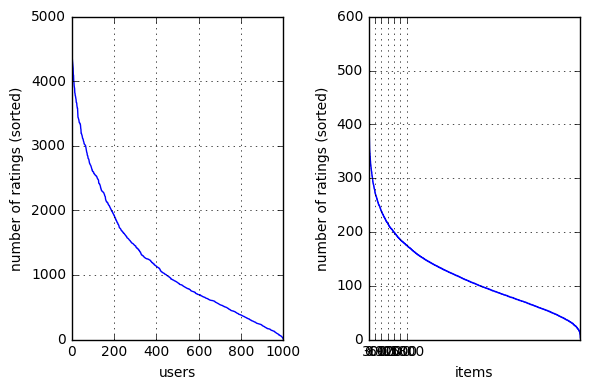

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Implementing Baselines 

#### Initialize matrix factorization

In [5]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    
    user_features = 3 * np.random.rand( num_features, train.shape[1])
    item_features = 3 * np.random.rand( num_features, train.shape[0])
    
    item_features[0, :] = train[train != 0].mean(axis = 1)
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [6]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    X = np.dot ( np.transpose(item_features), user_features )
    
    rmse = 0
    counter = 0
    for i, j in nz:
        
        rmse += (data[i,j] - X[i,j])**2
        counter += 1
    
    rmse = rmse/(counter)
    return rmse

### Learn the Matrix Factorization using Alternating Least Squares

In [41]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user):   #, nz_user_itemindices
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    N = train.shape[1]
    D = train.shape[0]
    K = item_features.shape[0]
    
    new_user_features = np.zeros((K, N))
    
    #print("UPDATE USER")
    for g , value in nnz_items_per_user:
    
        #print("column index = ", g)
        #print("elementebis raodenoba = ", value.shape)
        #scipy lil sparse matrixisdan ro gadaviyvanot numpy arrayshi
        #print(g)
        X = train[value, g].toarray()
        #print("shape of new train data = ", X.shape)
        Wt = item_features[: , value]
        #print("shape of Wt = ", Wt.shape)
        #print(type(Wt))
        #print(type(X))
        new_user_features[:, g] = np.linalg.solve( 
            np.dot(Wt, np.transpose(Wt))+ lambda_user* value.shape[0]* np.eye(K) ,
            np.dot( Wt, X)).flatten()
    
    
    return new_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item):   #, nz_item_userindices
    """update item feature matrix."""
    N = train.shape[1]
    D = train.shape[0]
    K = user_features.shape[0]
        
    new_item_features = np.zeros((K, D))
    #print("UPDATE ITEM")
    for g, value  in nnz_users_per_item:
        
        #print("column index = ", g)
        #print("elementebis raodenoba = ", value.shape)
        
        X = train[g,value].toarray()
        #print("shape of new train data = ", X.shape)
        Zt = user_features[: , value]
        #print("shape of Zt = ", Zt.shape)
        new_item_features[:, g] = np.linalg.solve( 
            np.dot(Zt, np.transpose(Zt))+ lambda_item * value.shape[0]* np.eye(K)  ,
            np.dot( Zt, np.transpose(X))).flatten()
        
    
    return new_item_features
    

In [42]:
from helpers import build_index_groups


def ALS (train , test, num_features,lambda_user, 
         lambda_item, stop_criterion,error_list,rng ):
    
    # initialize user and movies latent matrices
    user_features, item_features = init_MF(train, num_features)
    
    
    #indices of nonzero elements
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)   
   
  
    #print(nz_train)
    #print(nz_row_colindices )
    print("Original data shape: ", train.shape)
    #print(nz_train.shape)
    #print(nz_row_colindices.shape)
    #print(nz_col_rowindices)
    #i=0
                
    #while True:
    for i in range(rng):

        user_features_new = update_user_feature(
            train, item_features, lambda_user, nz_col_rowindices)
        if( user_features_new.shape != user_features.shape):
            print("AAAAA")
        item_features_new = update_item_feature(
            train, user_features_new, lambda_item, nz_row_colindices)


        '''rmse_tr = compute_error(train, user_features_new, item_features_new , nz_train)
        rmse_te = compute_error(test, user_features_new, item_features_new , nz_test)
        if i % 5 == 0:
            train_errors.append(rmse_tr)
            test_errors.append(rmse_te)
        print("iter: {}, RMSE on training set: {}.".format(i, rmse_tr))
        print("iter: {}, RMSE on test set: {}.".format(i, rmse_te))'''
        #i +=1
        if np.linalg.norm(item_features_new - item_features ) < stop_criterion and np.linalg.norm(user_features_new - user_features ) < stop_criterion:
            break

        item_features = item_features_new
        user_features = user_features_new
    
    
    rmse_te = compute_error(test, user_features, item_features, nz_test)
    rmse_tr = compute_error(train, user_features, item_features, nz_train)
    print("Final RMSE on test data: {}.".format(rmse_te))

    return rmse_tr, rmse_te
    

In [97]:
def gen_train_test(ratings, nz_ratings, i_ind , j_ind):
    
    #estimating shape
    d = ratings.shape[0]
    n = ratings.shape[1] 
    
    
    train_index = [ nz_ratings[i] for i in i_ind]
    test_index = [ nz_ratings[j] for j in j_ind]

    print("train index size = ", len(train_index))
    print("test index size = ", len(test_index))

    
    if len(train_index) + len(test_index) != len(nz_ratings):
        print("Wrong !!")

    train = np.zeros((d,n )) 
    test  = np.zeros((d,n))

    for ind in train_index:
        i = ind[0]
        j = ind[1]
        train[i,j] = ratings[i,j]
        
    for ind in test_index:
        i = ind[0]
        j = ind[1]
        test[i,j] = ratings[i,j]
        
    train = sp.lil_matrix(train)
    test = sp.lil_matrix(test)
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    print("nonzero elems in train: ", len(nz_train))
    print("nonzero elems in test: ", len(nz_test))
    
    return train, test
    

In [100]:
def cross_validation(
    ratings, n_of_splits,num_features,lambdas,
    stop_criterion, error_list, rng):

   
    #cross_validation(n_splits)
    kf = skm.KFold(n_splits=n_of_splits, shuffle = True)
    
    #creating matrix of non-zero indices
    nz_row, nz_col = ratings.nonzero()
    nz_ratings = list(zip(nz_row, nz_col))
    
    print("Length of list of nonzero elems of ratings is : ", len(nz_ratings) )
    
    t = range(nz_row.shape[0])
    
    #t = nz_row.shape[0]
    #nz_row = nz_row.reshape(t,1)
    #nz_col = nz_col.reshape(t,1)
    #nz_ratings = np.concatenate((nz_row, nz_col), axis = 1)
    
    #print(nz_row.shape)
    #print(nz_col.shape)
    #print(nz_ratings.shape)
    
    # creating matrix where results of cross validation are stored
    test_avg_cost =  np.zeros(len(lambdas))
    train_avg_cost = np.zeros(len(lambdas))

     
    for ind,lambda_ in enumerate(lambdas):
            
        lambda_user = lambda_[0]
        lambda_item = lambda_[1]
            
        avg_train = 0
        avg_test = 0
            
        print("lambda user = ",lambda_user, "lambda item = ", lambda_item)

        for i, j in kf.split(t):
            
            
            
            print("train: ",i.shape)
            print("test: ",j.shape)
            print(j)
            print("Percentage of train and test reps. : ", 
                  len(i)*100/nz_row.shape[0],"% ", len(j)*100/nz_row.shape[0],"%" )
            
            train , test = gen_train_test(ratings, nz_ratings, i , j)
            rmse_tr, rmse_te = ALS (train , test, num_features,lambda_user, 
                                    lambda_item, stop_criterion,error_list,rng )
                
            avg_train += rmse_tr
            avg_test += rmse_te
                    
                
                
        avg_train /= n_of_splits
        avg_test /= n_of_splits
        test_avg_cost[ind] = avg_test
        train_avg_cost[ind] = avg_train
    
    return test_avg_cost, train_avg_cost
            


In [113]:
def main(ratings):
    
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.1
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    rng = 250
    
    #initialization
    sratings = sp.lil_matrix(ratings)
    train_errors = []
    test_errors = []
    
    lambdas_user = np.linspace( 0.1, 1, 5)
    lambdas_item = np.linspace( 0.1, 1, 5)
    lambdas = [(x, y) for x in lambdas_user for y in lambdas_item]
   
    print("number of different pairs of lambdas : ",len(lambdas))
    
    # set seed
    np.random.seed(988)
    
    
    test_avg_cost, train_avg_cost = cross_validation(
        sratings, 10, num_features, lambdas, stop_criterion, error_list, rng)
    
    ratings_full = np.dot(np.transpose(item_features),user_features)
    
    return ratings_full, train_errors, test_errors
    


ratings_full, train_errors, test_errors = main(ratings)

number of different pairs of lambdas :  1
Length of list of nonzero elems of ratings is :  1226
lambda user =  0.1 lambda item =  0.1
train:  (1103,)
test:  (123,)
[   1   15   20   40   42   51   68   77   98  115  118  120  127  131  141
  150  156  164  171  174  183  184  195  198  205  206  209  214  218  226
  235  237  245  246  259  289  295  302  304  306  323  341  366  368  382
  402  420  425  437  438  472  478  479  480  490  494  498  500  501  503
  507  510  530  540  546  560  590  591  596  600  609  624  637  655  660
  679  690  698  722  730  731  781  790  793  803  805  817  821  843  846
  847  848  858  861  873  914  918  961  963  972  976  996 1002 1010 1033
 1035 1054 1066 1074 1076 1096 1097 1108 1112 1118 1128 1150 1167 1172 1181
 1185 1186 1204]
Percentage of train and test reps. :  89.9673735725938 %  10.0326264274062 %
train index size =  1103
test index size =  123
nonzero elems in train:  1103
nonzero elems in test:  123
Original data shape:  (100, 

KeyboardInterrupt: 

In [74]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(rng), train_errors, marker='o', label='Training Data');
plt.plot(range(rng), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.savefig("../results/test_train_rmse")
plt.show()

NameError: name 'train_errors' is not defined

In [44]:
import scipy.sparse as sp

print(ratings_full.shape)
print(ratings.shape)
path_dataset = "../submission/sampleSubmission.csv"
ratings_nonzero  = load_data(path_dataset)
(rows, cols, data) = sp.find(ratings_nonzero)
assert 1176952 == len(rows), "Not enough predictions!"

(10000, 1000)
(10000, 1000)
number of items: 10000, number of users: 1000


In [45]:
from our_helpers import create_submission
path_output = "submission.csv"

create_submission(path_output, rows, cols, ratings_full)

# test ALT

In [110]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    
    print("num_items_per_user shape: ", num_items_per_user.shape)
    print("num_users_per_item: ", num_users_per_item.shape)
    
    # set seed
    np.random.seed(988)
    
    #print(np.where(num_items_per_user >= min_num_ratings))
    # select user and item based on the condition.
    #in our case where will return tuple, because there is just condition in parameters
    #so it will be a tuple consisting of an array, so we need to extract it first
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    #valid_ratings = ratings[valid_items, :][: , valid_users] 
    valid_ratings = ratings
    print( valid_items.shape)
    print(valid_ratings.shape)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    
    n = valid_ratings.shape[0]
    m = valid_ratings.shape[1] 
    
    train = sp.lil_matrix((n,m )) 
    test  = sp.lil_matrix((n,m)) 
    
    for i in range(n):
        for j in range(m):
            
            if np.random.ranf() > 0.9 :
                test[i,j] = valid_ratings[i,j]
    
            else:
                train[i,j] = valid_ratings[i,j]
                
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in valid data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    print("Percentage  train and test = ", train.nnz *100 /valid_ratings.nnz , "%, ",test.nnz *100 /valid_ratings.nnz, "%" )
    return valid_ratings, train, test

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
ratings_full, train_errors, test_errors = ALS(train, test,10, 0.1,0.1,1e-4, [0, 0], 50)

num_items_per_user shape:  (1000,)
num_users_per_item:  (10000,)
(9990,)
(100, 101)
Total number of nonzero elements in origial data:1226
Total number of nonzero elements in valid data:1226
Total number of nonzero elements in train data:1103
Total number of nonzero elements in test data:123
Percentage  train and test =  89.9673735725938 %,  10.0326264274062 %
Original data shape:  (100, 101)
iter: 0, RMSE on training set: 0.7913093892098664.
iter: 0, RMSE on test set: 2.9781570716647927.
iter: 1, RMSE on training set: 0.3277872515224942.
iter: 1, RMSE on test set: 2.622742020295455.
iter: 2, RMSE on training set: 0.2222857010770707.
iter: 2, RMSE on test set: 2.5270773702013813.
iter: 3, RMSE on training set: 0.17595125564000597.
iter: 3, RMSE on test set: 2.460270317007652.
iter: 4, RMSE on training set: 0.14978420283358082.
iter: 4, RMSE on test set: 2.3863512376035283.
iter: 5, RMSE on training set: 0.1327626986836276.
iter: 5, RMSE on test set: 2.324323809192857.
iter: 6, RMSE on t

ValueError: not enough values to unpack (expected 3, got 2)